## Theta Absolute Power Topography

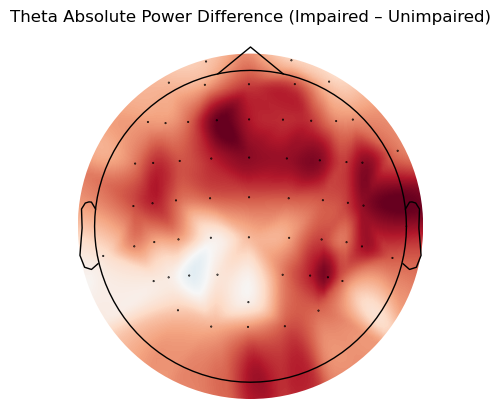

In [5]:
import os
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt

BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
META_PATH = "participants.csv"

meta = pd.read_csv(META_PATH)
pd_subs = meta.loc[meta['GROUP'] == 'PD', 'participant_id'].tolist()

# Storage: channel -> list of theta values for each group
theta_imp = {}
theta_unimp = {}

for subj in pd_subs:
    csv_file = os.path.join(BASE_DIR, subj, "data", f"{subj}_bandpowers_epoch.csv")
    if not os.path.exists(csv_file):
        continue

    df = pd.read_csv(csv_file)
    df['channel'] = df['channel'].str.strip().str.upper()

    moca = meta.loc[meta['participant_id'] == subj, 'MOCA'].values
    if len(moca) == 0 or np.isnan(moca[0]):
        continue

    label = int(moca[0] < 26)  # 1 = impaired

    for _, row in df.iterrows():
        ch = row['channel']
        val = row['theta_abs']

        if label == 1:
            theta_imp.setdefault(ch, []).append(val)
        else:
            theta_unimp.setdefault(ch, []).append(val)

# Keep only channels present in both groups
common_ch = sorted(set(theta_imp.keys()).intersection(theta_unimp.keys()))

imp_mean = np.array([np.mean(theta_imp[ch]) for ch in common_ch])
unimp_mean = np.array([np.mean(theta_unimp[ch]) for ch in common_ch])

diff = imp_mean - unimp_mean   # impaired – unimpaired

# ---- Build MNE object for topomap ----
info = mne.create_info(common_ch, sfreq=250, ch_types="eeg")
montage = mne.channels.make_standard_montage("standard_1020")
# --- Fix channel name capitalization (AFZ -> AFz, CPZ -> CPz, etc.)
def fix_channel_name(ch):
    ch = ch.strip()
    if ch.upper() == "FP1": return "Fp1"
    if ch.upper() == "FP2": return "Fp2"
    if ch.endswith("Z"): return ch[:-1] + "z"
    return ch

fixed_ch = [fix_channel_name(ch) for ch in common_ch]

info = mne.create_info(fixed_ch, sfreq=250, ch_types="eeg")
montage = mne.channels.make_standard_montage("standard_1020")
info.set_montage(montage)


info.set_montage(montage)

# ---- Plot ----
fig, ax = plt.subplots()
mne.viz.plot_topomap(diff, info, contours=0, axes=ax, show=False)
ax.set_title("Theta Absolute Power Difference (Impaired – Unimpaired)")
plt.show()


## Temporal Correlation Heatmaps

In [2]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, pearsonr

# -------------------------------
# Configuration
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
PARTICIPANTS_CSV = os.path.join(BASE_DIR, "participants.csv")
BANDS = ["theta", "alpha"]
WINDOW_FOLDER = "data"
MOCA_THRESHOLD = 26

# -------------------------------
# Load participants
# -------------------------------
df = pd.read_csv(PARTICIPANTS_CSV, dtype={"participant_id": str})
df.set_index("participant_id", inplace=True)

moca_col = "MOCA" if "MOCA" in df.columns else "MoCA"
if moca_col not in df.columns:
    raise ValueError("MOCA column not found in participants CSV")

pd_df = df[df["GROUP"].str.upper() == "PD"].copy()
subjects = pd_df.index.tolist()

# -------------------------------
# Feature extraction functions
# -------------------------------
def compute_fctv(pli_windows):
    return np.std(pli_windows, axis=0)

def compute_temporal_corr(pli_windows):
    """Mean correlation between consecutive windows; returns np.nan if undefined"""
    n_win = pli_windows.shape[0]
    if n_win < 2:
        return np.nan  # Not enough windows to correlate
    corrs = []
    for i in range(n_win - 1):
        v1 = pli_windows[i].flatten()
        v2 = pli_windows[i + 1].flatten()
        # Skip pairs with zero variance
        if np.std(v1) == 0 or np.std(v2) == 0:
            continue
        corrs.append(np.corrcoef(v1, v2)[0, 1])
    if len(corrs) == 0:
        return np.nan
    return np.mean(corrs)


def compute_electrode_variability(pli_windows):
    """Variability per electrode across all connections and time"""
    n_ch = pli_windows.shape[1]
    var_list = []
    for ch in range(n_ch):
        conn_vals = pli_windows[:, ch, :].copy()
        # Remove self-connections only if matrix is square
        if pli_windows.shape[2] >= n_ch:
            conn_vals[:, ch] = np.nan
        var_list.append(np.nanmean(np.std(conn_vals, axis=0)))
    return np.array(var_list)


# -------------------------------
# Loop over subjects and bands
# -------------------------------
all_results = []

for subj in subjects:
    subj_data_folder = os.path.join(BASE_DIR, subj, WINDOW_FOLDER)
    for band in BANDS:
        pli_file = os.path.join(subj_data_folder, f"{subj}_{band}_pli_windows.npy")
        if not os.path.exists(pli_file):
            print(f"{subj} {band}: PLI windows not found, skipping")
            continue

        pli_windows = np.load(pli_file)
        if pli_windows.ndim != 3:
            print(f"{subj} {band}: invalid shape {pli_windows.shape}, skipping")
            continue

        fctv = compute_fctv(pli_windows)
        temporal_corr = compute_temporal_corr(pli_windows)
        electrode_var = compute_electrode_variability(pli_windows)

        all_results.append({
            "subject": subj,
            "band": band,
            "FCTV_mean": np.nanmean(fctv),
            "TemporalCorr": temporal_corr,
            "ElectrodeVar_mean": np.nanmean(electrode_var),
            "ElectrodeVar_max": np.nanmax(electrode_var),
            "MOCA": pd_df.at[subj, moca_col]
        })

# -------------------------------
# Convert to DataFrame
# -------------------------------
df_feat = pd.DataFrame(all_results)
df_feat["impaired"] = df_feat["MOCA"] < MOCA_THRESHOLD

# -------------------------------
# Statistical testing
# -------------------------------
for band in BANDS:
    sub = df_feat[df_feat["band"] == band]
    impaired = sub[sub["impaired"]]
    unimpaired = sub[~sub["impaired"]]

    print(f"\n--- {band.upper()} band ---")
    for feat in ["FCTV_mean", "TemporalCorr", "ElectrodeVar_mean", "ElectrodeVar_max"]:
        if len(impaired) >= 3 and len(unimpaired) >= 3:
            t_stat, p_val = ttest_ind(impaired[feat], unimpaired[feat], equal_var=False)
            r, p_corr = (pearsonr(sub[feat], sub["MOCA"]) if len(sub) >= 4 else (np.nan, np.nan))
            print(f"{feat}: t={t_stat:.3f}, p={p_val:.6g} | r={r:.3f}, p_corr={p_corr:.6g}")



--- THETA band ---
FCTV_mean: t=0.101, p=0.919647 | r=-0.123, p_corr=0.22324
TemporalCorr: t=-2.209, p=0.0295459 | r=0.285, p_corr=0.00411253
ElectrodeVar_mean: t=0.101, p=0.919647 | r=-0.123, p_corr=0.22324
ElectrodeVar_max: t=-0.113, p=0.910252 | r=-0.081, p_corr=0.420442

--- ALPHA band ---
FCTV_mean: t=-0.792, p=0.430497 | r=0.113, p_corr=0.2644
TemporalCorr: t=-1.319, p=0.190205 | r=0.132, p_corr=0.190358
ElectrodeVar_mean: t=-0.792, p=0.430497 | r=0.113, p_corr=0.2644
ElectrodeVar_max: t=-0.669, p=0.504969 | r=0.107, p_corr=0.287411


In [3]:
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"

# -------- CHOOSE SUBJECT & BAND HERE ----------
subj = "sub-146"
band = "theta"   # "theta" or "alpha"
# ---------------------------------------------

pli_path = os.path.join(BASE_DIR, subj, "data", f"{subj}_{band}_pli_windows.npy")
pli_windows = np.load(pli_path)


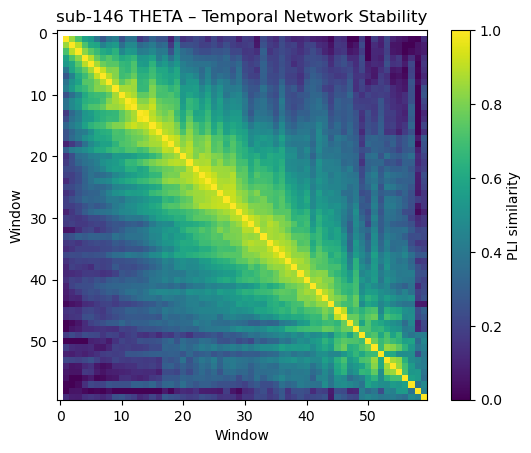

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_temporal_corr_matrix(pli_windows, subj, band):
    n_win = pli_windows.shape[0]
    corr_mat = np.zeros((n_win, n_win))

    for i in range(n_win):
        for j in range(n_win):
            v1 = pli_windows[i].flatten()
            v2 = pli_windows[j].flatten()
            if np.std(v1) == 0 or np.std(v2) == 0:
                corr_mat[i, j] = np.nan
            else:
                corr_mat[i, j] = np.corrcoef(v1, v2)[0, 1]

    plt.imshow(corr_mat, vmin=0, vmax=1)
    plt.colorbar(label="PLI similarity")
    plt.title(f"{subj} {band.upper()} – Temporal Network Stability")
    plt.xlabel("Window")
    plt.ylabel("Window")
    plt.show()
plot_temporal_corr_matrix(pli_windows, subj, band)

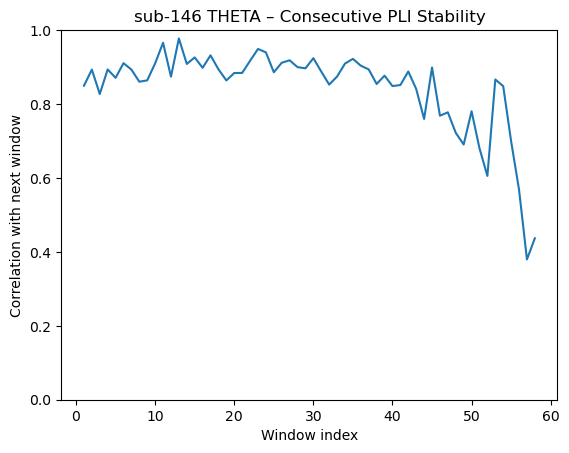

In [5]:

def plot_temporal_corr_trace(pli_windows, subj, band):
    corrs = []
    for i in range(len(pli_windows) - 1):
        v1 = pli_windows[i].flatten()
        v2 = pli_windows[i + 1].flatten()
        if np.std(v1) == 0 or np.std(v2) == 0:
            corrs.append(np.nan)
        else:
            corrs.append(np.corrcoef(v1, v2)[0, 1])

    plt.plot(corrs)
    plt.ylim(0, 1)
    plt.xlabel("Window index")
    plt.ylabel("Correlation with next window")
    plt.title(f"{subj} {band.upper()} – Consecutive PLI Stability")
    plt.show()
plot_temporal_corr_trace(pli_windows, subj, band)


--- THETA Temporal Network Stability ---
n_unimpaired = 47, n_impaired = 53
Mean_unimpaired = 0.8566
Mean_impaired   = 0.8471
Cohen's d = -0.443
Welch t = -2.209, p = 0.0295459


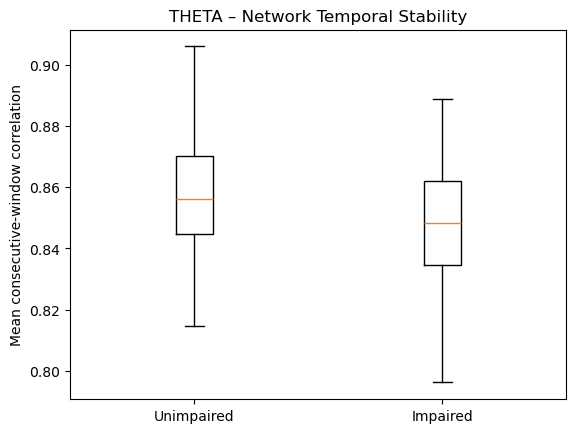

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

def plot_group_temporal_corr_quant(df_feat, band):
    sub = df_feat[df_feat["band"] == band]
    imp = sub[sub["impaired"]]["TemporalCorr"].dropna()
    unimp = sub[~sub["impaired"]]["TemporalCorr"].dropna()

    # Stats
    t, p = ttest_ind(imp, unimp, equal_var=False)
    d = (imp.mean() - unimp.mean()) / np.sqrt((imp.var() + unimp.var()) / 2)
    print(f"\n--- {band.upper()} Temporal Network Stability ---")
    print(f"n_unimpaired = {len(unimp)}, n_impaired = {len(imp)}")
    print(f"Mean_unimpaired = {unimp.mean():.4f}")
    print(f"Mean_impaired   = {imp.mean():.4f}")
    print(f"Cohen's d = {d:.3f}")
    print(f"Welch t = {t:.3f}, p = {p:.6g}")
    # Plot
    fig, ax = plt.subplots()
    ax.boxplot([unimp, imp], tick_labels=["Unimpaired", "Impaired"])

    ax.set_ylabel("Mean consecutive-window correlation")
    ax.set_title(f"{band.upper()} – Network Temporal Stability")


plot_group_temporal_corr_quant(df_feat, "theta")


## Connectivity Visual Frontal - Delta - Posterior

In [6]:
import numpy as np
import mne
import matplotlib.pyplot as plt

# -------------------------------
# Config
# -------------------------------
SUBJ = PD_SUBS[0]  # pick one subject for example
BAND = 'beta'
f_idx, _ = subj_cache[SUBJ]

# Load the PLI matrix
mat_path = os.path.join(BASE_DIR, SUBJ, "data", f"{SUBJ}_{BAND}_pli_matrix.npy")
pli_mat = np.load(mat_path)

# Ensure symmetry
pli_mat = pli_mat + pli_mat.T - np.diag(np.diag(pli_mat))

# Get MNE layout info
# Use standard 10-20 montage
montage = mne.channels.make_standard_montage('standard_1020')

# Pick only frontal channels
ch_names = [c.upper() for c in FRONTAL_CH if c.upper() in montage.ch_names]
frontal_idx = [montage.ch_names.index(c) for c in ch_names]

# -------------------------------
# Topographic plot of mean frontal connectivity
# -------------------------------
# Compute mean PLI per frontal channel
mean_pli = np.nanmean(pli_mat[np.ix_(frontal_idx, frontal_idx)], axis=1)

# Create an info object
info = mne.create_info(ch_names=ch_names, sfreq=1000, ch_types='eeg')
info.set_montage(montage)

# Create EvokedArray to hold mean values
evoked_data = np.expand_dims(mean_pli, axis=1)  # channels x times
evoked = mne.EvokedArray(evoked_data, info, tmin=0)

# Plot topomap
plt.figure(figsize=(6, 5))
evoked.plot_topomap(times=0, scalings=1, time_format='', cmap='Reds', show=True)
plt.title(f'{SUBJ} - Frontal Beta Mean PLI')

# -------------------------------
# Network plot
# -------------------------------
# Build adjacency for frontal channels
pli_frontal = pli_mat[np.ix_(frontal_idx, frontal_idx)]

plt.figure(figsize=(6, 6))
mne.viz.plot_connectivity_circle(pli_frontal, ch_names, n_lines=pli_frontal.size, title='Frontal Beta Network', show=True)


NameError: name 'PD_SUBS' is not defined

In [ ]:
import matplotlib.pyplot as plt
import mne
import numpy as np
import os

def plot_group_difference_topomap(subj_list, band, ch_names, roi_indices, labels):
    """
    Plot difference map: impaired minus unimpaired for a ROI.
    
    Parameters
    ----------
    subj_list : list of subject IDs
    band : str
    ch_names : full montage list (e.g., 60 channels)
    roi_indices : list of ROI channel indices (e.g., 30 indices)
    labels : list of 0/1 group labels (0 = unimpaired, 1 = impaired)
    """
    def fix_ch(ch):
        ch = ch.strip()
        if ch.upper() == "FP1": return "Fp1"
        if ch.upper() == "FP2": return "Fp2"
        if ch.endswith("Z"): return ch[:-1] + "z"
        return ch

    ch_names_fixed = [fix_ch(ch) for ch in ch_names]

    # Split PLI matrices by group
    imp_vals, unimp_vals = [], []

    for subj, label in zip(subj_list, labels):
        # Update this path if necessary
        pli_path = f"C:/Users/User/Documents/EEG_Project/rEEG/{subj}/data/{subj}_{band}_pli_matrix.npy"
        
        if not os.path.exists(pli_path):
            print(f"Warning: Path not found for {subj}")
            continue

        mat = np.load(pli_path)
        # Symmetrize the matrix
        mat = mat + mat.T - np.diag(np.diag(mat))
        
        # Extract the ROI sub-matrix and calculate mean connectivity per channel
        roi_mat = mat[np.ix_(roi_indices, roi_indices)]
        ch_vals = np.nanmean(roi_mat, axis=0)

        if label == 1:
            imp_vals.append(ch_vals)
        else:
            unimp_vals.append(ch_vals)

    # Calculate group means and the difference
    imp_mean = np.nanmean(np.array(imp_vals), axis=0)
    unimp_mean = np.nanmean(np.array(unimp_vals), axis=0)
    diff = imp_mean - unimp_mean

    # --- MNE INFO SETUP ---
    # 1. Create info for ALL channels first
    info_full = mne.create_info(ch_names_fixed, sfreq=250, ch_types='eeg')
    montage = mne.channels.make_standard_montage('standard_1020')
    info_full.set_montage(montage, on_missing='ignore')

    # 2. Subset the info to match the ROI data (Fixes the ValueError)
    info_roi = mne.pick_info(info_full, sel=roi_indices)

    # 3. Define symmetrical limits for the colorbar
    vlimit = np.nanmax(np.abs(diff))

    # --- PLOTTING ---
    fig, ax = plt.subplots(figsize=(8, 6))
    
    im, _ = mne.viz.plot_topomap(
        data=diff,
        pos=info_roi,
        vlim=(-vlimit, vlimit),
        contours=0,
        cmap="RdBu_r",
        axes=ax,
        show=False
    )

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('$\Delta$ PLI (Impaired - Unimpaired)')

    plt.title(f"{band.upper()} Band: Connectivity Difference\n(ROI Mean PLI)")
    plt.show()

# Example usage (ensure these variables are defined in your workspace):
plot_group_difference_topomap(subj_list, 'alpha', ch_names, roi_indices, labels)

NameError: name 'subj_list' is not defined